# Classify engaged users using Xgboost
Train an Xgboost model for binary classsifcation of the enaged and unenaged user.

In [1]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import os
import pandas as pd
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
style.use('ggplot')
from IPython.display import display, HTML
from pylab import rcParams
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Read the features dataset
Convert relevant columns to categorical for one hot encoding.

In [2]:
users= pd.read_csv("user_features.csv")

In [3]:
users["user_settings_crypto_unlocked"] = users.user_settings_crypto_unlocked.astype('category')
users["plan"] = users.plan.astype('category')
users["attributes_notifications_marketing_push"] = users.attributes_notifications_marketing_push.astype('category')
users["attributes_notifications_marketing_email"] = users.attributes_notifications_marketing_email.astype('category')
users["brand"] = users.brand.astype('category')

users.dtypes

user_id                                       object
user_settings_crypto_unlocked               category
plan                                        category
attributes_notifications_marketing_push     category
attributes_notifications_marketing_email    category
num_contacts                                   int64
brand                                       category
age                                            int64
days_since_creation                            int64
country_counts                                 int64
city_counts                                    int64
days_since_last_sent_notif                   float64
number_of_notifs                             float64
number_of_emails                             float64
number_of_push                               float64
number_of_sms                                float64
number_failed_notif                          float64
number_sent_notif                            float64
number_reengagement_notif                    f

### Correlations
We can see some of the features such as number of contacts, number of transactions, number of failed notification, days since last notificatoin and the counts of types of transactions being correlated (positively or negatively)  with our target column.

In [4]:
users.corrwith(users['is_unengaged']).sort_values()

number_of_trans              -0.265294
completed_pending_count      -0.257519
other_state_count            -0.222630
num_contacts                 -0.153259
number_failed_notif          -0.119022
number_of_push               -0.106389
number_of_notifs             -0.075024
number_of_emails             -0.029418
number_reengagement_notif    -0.021413
city_counts                  -0.021291
transaction_max              -0.010715
number_sent_notif            -0.008032
transaction_mean             -0.005672
number_of_sms                 0.020644
age                           0.054701
days_since_creation           0.078466
number_no_card_notif          0.081106
transaction_min               0.094611
country_counts                0.098703
days_since_last_sent_notif    0.160315
is_unengaged                  1.000000
dtype: float64

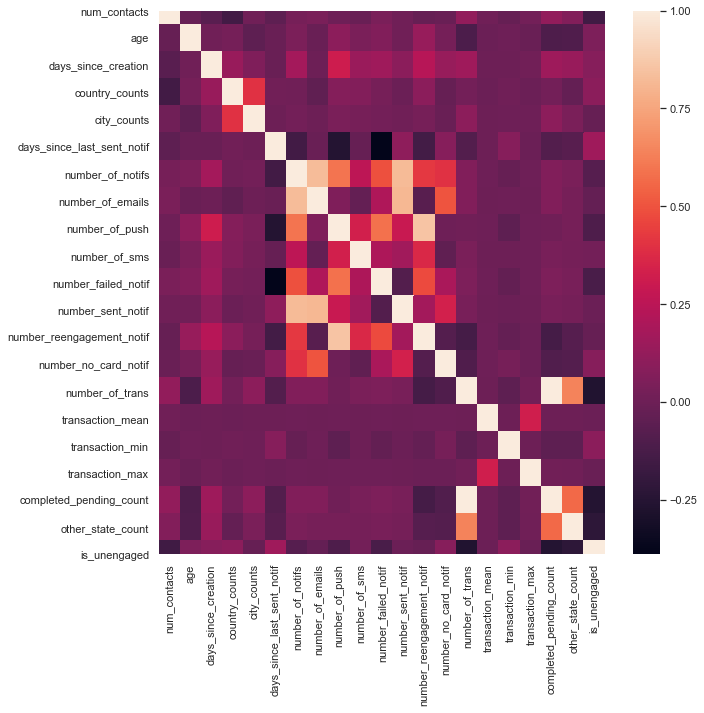

In [5]:
sns.set(rc={'figure.figsize': (10, 10)})
corr = users.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


### One hot encode the categorical features

In [6]:
cat_columns = []
for index in users.dtypes.index:
    if index != 'user_id' and index != 'is_unengaged':
        if(not("float" in str(users.dtypes[index])
               or "int" in str(users.dtypes[index]))):
            cat_columns.append(index)
cat_columns            

['user_settings_crypto_unlocked',
 'plan',
 'attributes_notifications_marketing_push',
 'attributes_notifications_marketing_email',
 'brand']

In [7]:
users = pd.get_dummies(users, columns=cat_columns)

In [8]:
print(users.is_unengaged.value_counts(dropna=False))
users = users[users['is_unengaged'].notna()]


0.0    14630
1.0     4136
NaN      664
Name: is_unengaged, dtype: int64


### Create the training and validation datasets

In [9]:
train, valid = train_test_split(users, test_size=0.2, random_state=42,
                                          stratify=users.is_unengaged)
print(train.shape, valid.shape)

(15012, 39) (3754, 39)


In [10]:
is_unengaged_train = train.is_unengaged
user_id_train = train.user_id
train = train[train.columns.difference(['user_id', 'is_unengaged'])]

X_train = np.array(train)
y_train = np.array(is_unengaged_train.astype('category'))
print(X_train.shape, y_train.shape)

(15012, 37) (15012,)


In [11]:
is_unengaged_valid = valid.is_unengaged
user_id_valid = valid.user_id
valid = valid[valid.columns.
              difference(['user_id', 'is_unengaged'])]

X_valid = np.array(valid)
y_valid = np.array(is_unengaged_valid.astype('category'))
print(X_valid.shape, y_valid.shape)

(3754, 37) (3754,)


## XgBoost model training
I am using grid search CV. Further given the imbalance between the engaged and unengaged users, I am also weighting the positive class i.e. unengaged users.

In [12]:
scale_pos_weight = y_train.shape[0]/np.sum(y_train == 1)-1.0
scale_pos_weight

3.536718041704442

In [13]:
params = {
            'scale_pos_weight': [scale_pos_weight,1.0],
            'gamma': [5.0, 1.0],
            'early_stopping_rounds': [8],
            'max_depth': [7],
            'subsample': [.8],
            'colsample_bytree': [.8],
            'n_estimators': [150],
            'learning_rate': [0.05],
            'nthread': [5],
            'tree_method': ['hist']
        }

xgb_classifier = xgb.XGBClassifier(eval_metric='aucpr')
rs = GridSearchCV(xgb_classifier, params, cv=3,
                  n_jobs=1, scoring='f1', verbose=1)

In [14]:
rs.fit(X_train, y_train)
gbm = rs.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   20.6s finished


In [15]:
print(f"best score GBM: {rs.best_score_}\n"
                          f"best params GBM: {rs.best_params_}")

best score GBM: 0.7218188140298176
best params GBM: {'colsample_bytree': 0.8, 'early_stopping_rounds': 8, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150, 'nthread': 5, 'scale_pos_weight': 3.536718041704442, 'subsample': 0.8, 'tree_method': 'hist'}


### Model performance evaluation
* Test the model performance on the validation data set.
* Also plot the feature importances.

In [16]:
"""
Compute binary classification metrics
"""

def compute_validation_acc(model,features_test,target):
    predict_proba=model.predict_proba(features_test)
    predicted=model.predict(features_test)
    pred_prob=np.array(predict_proba[:,1])
    area_under_curve =  roc_auc_score(target,pred_prob)
    labels=['unenaged','engaged']
    print("accuracy score:",accuracy_score(target,model.predict(features_test)))
    print(target.shape,np.sum(predicted))
    cm=confusion_matrix(target,predicted)
    print(cm)
    
    sns.set(rc={'figure.figsize':(18,5)})
    fig, ax=plt.subplots(1,3)
    fig.suptitle("Metrics for binary classification", fontsize=16)
    
    #confusion matrix
    akws = {"ha": 'center',"va": 'center',"size": 17}
    sns.heatmap(cm, annot=True,ax=ax[0],annot_kws=akws); #annot=True to annotate cells
    ax[0].set_xlabel('Predicted labels')
    ax[0].set_ylabel('True labels'); 
    ax[0].set_title('Confusion Matrix') 
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)
    
    #ROC
    fpr, tpr, _ = metrics.roc_curve(target,  pred_prob)
    ax[1].plot(fpr,tpr,label=f"auc = {area_under_curve:.3f}")
    ax[1].set_xlabel('True positive rate')
    ax[1].set_title('ROC curve')
    ax[1].set_ylabel('False positive rate')
    ax[1].legend(loc="lower right")
    
    #precision recall
    precision, recall, thresholds = precision_recall_curve(target, pred_prob)
    f1 = f1_score(target, predicted)
    auc_pr = auc(recall, precision)
    ap = average_precision_score(target, pred_prob)
    print('f1=%.3f auc_pr=%.3f avg_pr=%.3f auc=%.3f' % (f1, auc_pr, ap,area_under_curve))
    
    ax[2].plot(precision,recall,label=f"auc_pr = {auc_pr:.3f}")
    ax[2].set_title('PR Curve')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].legend(loc="upper right")
    #plt.show()

accuracy score: 0.8556206712839638
(3754,) 1055.0
[[2542  385]
 [ 157  670]]
f1=0.712 auc_pr=0.788 avg_pr=0.788 auc=0.924


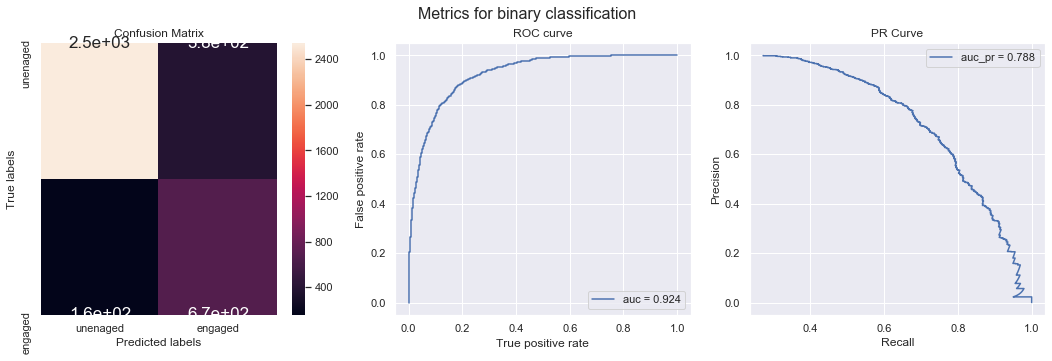

In [17]:
compute_validation_acc(gbm, X_valid,y_valid.astype(int))

Text(0, 0.5, 'Relative feature importance')

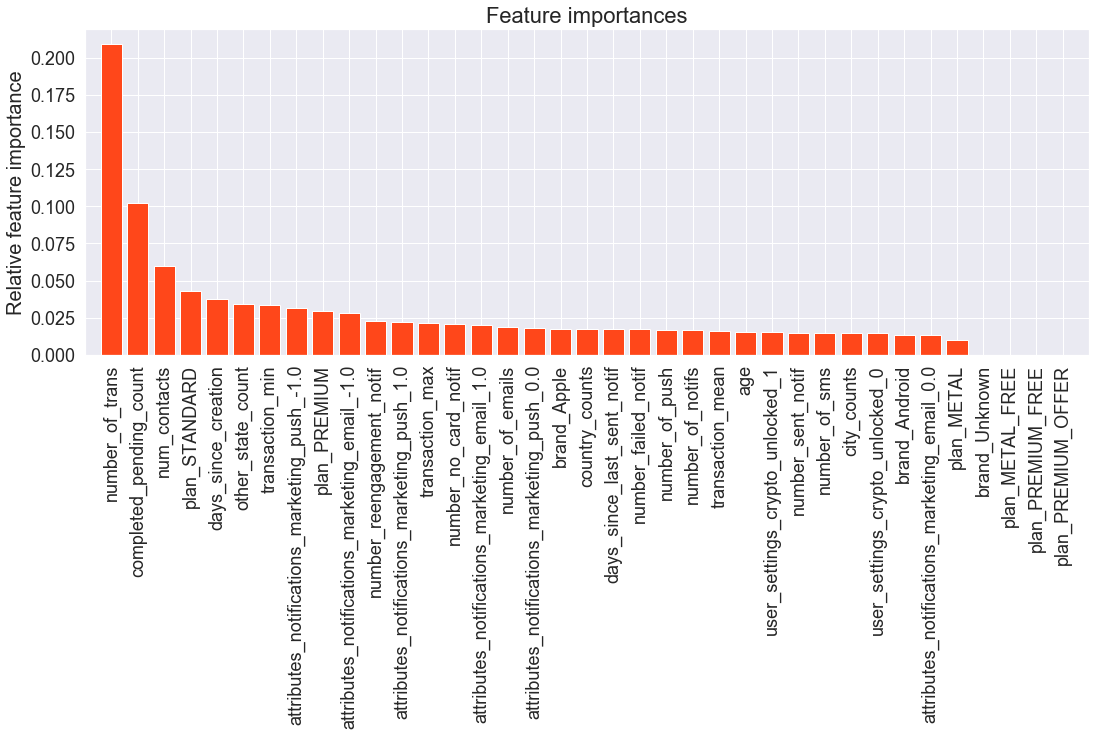

In [18]:
sorted_idx = np.argsort(gbm.feature_importances_)[::-1]
feature_importance = {}
for index in sorted_idx:
    feature_importance[train.columns[index]
                       ] = gbm.feature_importances_[index]

n_features = X_train.shape[1]
ss = sorted(feature_importance, key=feature_importance.get, reverse=True)
top_names = ss[0:]
f = plt.figure(figsize=(18, 6))
plt.grid(True)
plt.yticks(fontsize=18)
plt.xticks(range(n_features), top_names, rotation=90, fontsize=18)
plt.title("Feature importances", fontsize=22)
plt.bar(range(n_features), [feature_importance[i]
                            for i in top_names], color="#ff471a", align="center")
plt.xlim(-1, n_features)
plt.ylabel('Relative feature importance', fontsize=20)


## Conclusions
* The binary classifier, trained does not include the feature `days since last transaction` which was used to tag users as engaged or unengaged.
* The feature importance plot clearly shows that greater the number of transactons from a single user, lesser the likelihood of a user becoming unengaged. This is inline with the correlation as shown in one of the cells above.
* Despite the columns `number_of_trans` and `completed_pending_count` being highly correlated (exceeding $0.99$), I am including both since `other_state_count` is also a very important since users having a larger share of completed/pending transactions are much more likely to be engaged than those with a large number of reverted/declined/cancelled transactions.   
* Those having a large number of contacts are also less likely to disengage from the platform.
* The relevant metrics of the binary classification model are summarized below
$\text{f1}=0.712, auc_{pr}=0.788, average_{pr}=0.788, \text{auc}=0.924$
